Ideally, we would create a cat state and squeeze it.
However, we squeezed vacuum first and then create a cat. 
The purpose of this script is answer either of the following two questions
- given a cat, and a dB value, what is the corresponding displacement of the squeezed cat
- given a squeezed cat, what is the corresponding displacement of the original cat

$D(\alpha) S(\xi) = S(\xi) D(\gamma)$ with $\gamma = \alpha \ cosh(r) + \alpha^* e^{i\theta} sinh(r)$ , $\xi = re^{i\theta}$


# 0.  Imports - Helper functions - Load Data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import h5py
import time
from matplotlib.pyplot import figure, show
from matplotlib import gridspec
import os
import numpy.ma as ma
from scipy import optimize
import random
# kept them here. Rest of code works without those.
from tcsim.system import*
from tcsim.visualization import*
from tcsim.gates import*

In [3]:
X_oper = (a.dag()+a)/2
P_oper = (1j*(a.dag()-a))/2

def db_into_factor(x):
    return 10**(-x/10)
#  find the squeezing parameter corresponding to the db value
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def find_gamma(alpha, xi):
    return alpha*np.cosh(-xi)+ np.conjugate(alpha)*np.sinh(-xi)

#  used to fit a gaussian to extract alpha
def twoD_Gaussian(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


def find_parameters_for_given_squeezing(uvs, db):
    ideal_state = tensor(fock(2,0)*fock(2,0).dag(),squeeze(N,calc_squeez_parameter(1j*db)))*vac

    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
    
    print("Squeezing:", -10*np.log10(qt.expect(P_oper**2,psi3)*4))
    print("Overlap with ideal squeezed state:",(ideal_state.overlap(psi3)))
    return np.abs(1-ideal_state.overlap(psi3))


In [14]:
# load the data. change path to where you saved the data
d = "C:/Users/jonat/Desktop/Coding/tcsim/Data Analysis/Data/"
files = [f for f in os.listdir(d) if f.endswith('vcat_3db.h5')] 

# set this factor to the axis scaling of the data!
scaling = 3

### two Masks

In [8]:
# run this to load data with two masks
dg = []
de = []

for kk in range(len(files)):
    df = h5py.File(d + files[kk], "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    n_points = len(x)  # sweep points
    thresh = -5.6883636780292806e-05#1.736310313628283e-05 # we should load this instead of hardcoding it
    ss_data = np.where(data_i < thresh, 1, 0)
    m1 = ss_data[:, 0::2]  # .mean(axis=0) # first measurement, we use as mask
    m2 = ss_data[:, 1::2]  # .mean(axis=0) # second measurement
    mask = np.zeros_like(m1)
    mx_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    mx_e = (
        ma.masked_array(m2, mask=np.logical_not(m1))
        .mean(axis=0)
        .reshape(n_points, n_points)
    ) * 2 - 1
    mx_ge = m2.mean(axis=0).reshape(n_points, n_points) * 2 - 1
    
    #add all the data together 
    dg.append(mx_g)
    de.append(mx_e)
    
dg = np.array(dg)
de = np.array(de)
proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(x, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(x, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')

ValueError: cannot reshape array of size 13254 into shape (94,94)

### three Masks


Text(0.5, 1.0, 'proj_e')

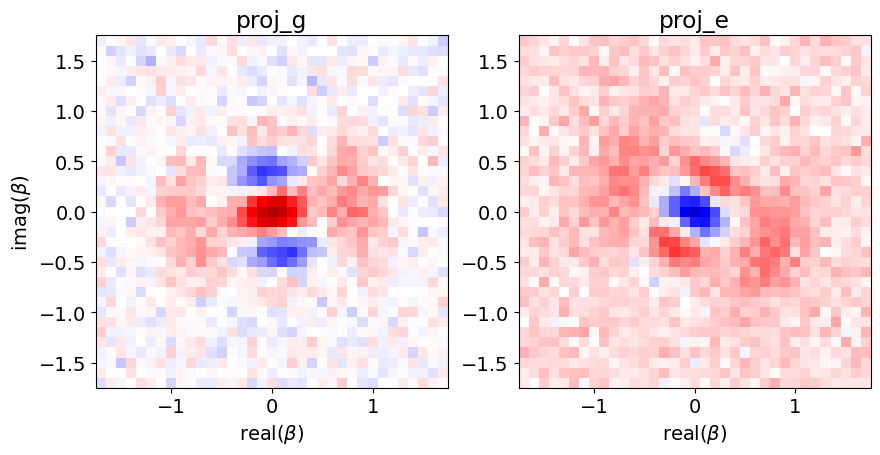

In [4]:
# run this to load data with three masks
dg = []
de = []
if 1:
    for kk in range(len(files)):
        fname = d + files[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]

        thresh = 6.30337300715842e-05
        ss_data = np.where(data_i < thresh, 1, 0)
        m0 = ss_data[:, 0::3]
        m1 = ss_data[:, 1::3] 
        m2 = ss_data[:, 2::3]
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        ## only care about last two measurements
        proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(len(x), len(y)) * 2 - 1
        proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(len(x), len(y)) * 2 - 1

        ## condition on the first measurement as well
        double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(len(x), len(y)) * 2 - 1

        dg.append(double_ps_g)
        de.append(double_ps_e)


dg = np.array(dg)
de = np.array(de)

proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = np.array([proj_g, proj_e]).mean(axis = 0)  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(x, y, proj_g.T, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(x, y, proj_e.T, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')

#fig.colorbar(f2)

# fig, ax = plt.subplots(1, figsize=(5, 5))
# f = ax.pcolormesh(y, x, proj_ge, cmap="seismic", vmax=1, vmin=-1)
# ax.set_aspect("equal")
# ax.set_xlabel(r"real($\beta$)")
# ax.set_ylabel(r"imag($\beta$)")
# ax.set_title('proj_ge')



# 1. Cat -> Squeezed Cat

### a) Find alpha

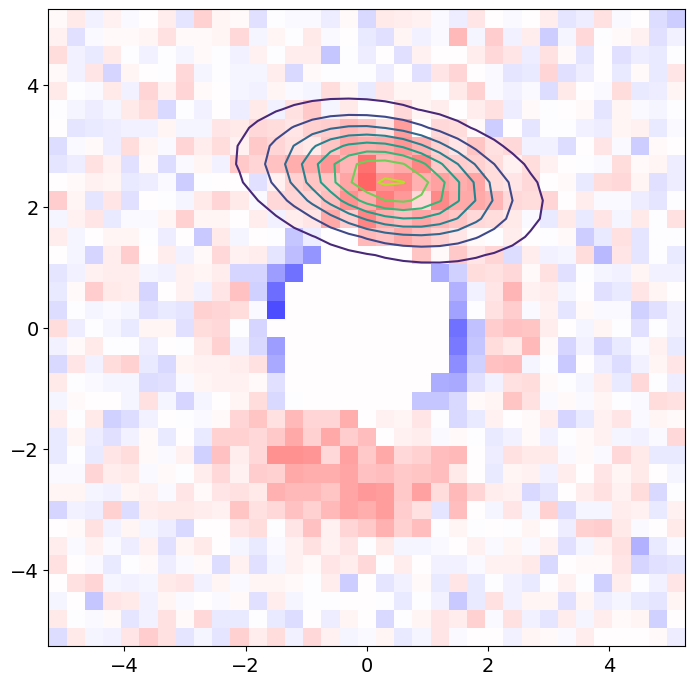

In [9]:
# finding alpha of the cat by fitting a gaussian to one of the blobs
""" 
Use the above plot to make good intial guesses!
Sometimes, fitting to e.g. the proj_e projection might work better.

"""
scaling = 3
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.1, 0, 3.4, 1, 1, 0, 0) # upper blob


xvec = x*scaling # i define it like this in case i want to slice x
yvec = y*scaling
X, Y = np.meshgrid(yvec, xvec)

data = proj_g

mask=np.zeros(np.shape(data))
mask[:,:] = 1
mask[np.abs(X**2+Y**2)<1.5**2]=0
data = data*mask

popt1, pcov1 = optimize.curve_fit(twoD_Gaussian, (X, Y), data.flatten(), p0=initial_guess)



data_fitted1 = twoD_Gaussian((X, Y), *popt1)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
ax.contour(yvec,xvec, data_fitted1.reshape(len(x),len(y)))
ax.set_aspect("equal")
plt.show()

In [10]:
print('xcenter:',popt1[1])
print('ycenter:',popt1[2])
print('|distance from origin| =',np.sqrt(popt1[1]**2+popt1[2]**2))
# dont forget the factor of two to convert it into an alpha if we are plotting char func.
alpha = np.sqrt(popt1[1]**2+popt1[2]**2)/2
print("\u03B1 is approximately = ", alpha) 

xcenter: 0.3664379896920896
ycenter: 2.4276411989476108
|distance from origin| = 2.455141256856186
α is approximately =  1.227570628428093


### b) Specify different squeezing parameters and calculate the corresponding gamma values

In [4]:
# I assume per default that xi is either fully real or imaginary    
alpha = 1.8
dBs = [0, 3,  5, 6,7]
gammas = [find_gamma(alpha, calc_squeez_parameter(db)) for db in dBs]
gammas


[1.8,
 1.274302411891448,
 1.0122143853426284,
 0.9021370205290902,
 0.8040304658717337]

### c) Find the paramters leading to a certain degree of of squeezing

In [41]:
def find_parameters_for_given_squeezing(uvs, db):
    ideal_state = tensor(fock(2,0)*fock(2,0).dag(),squeeze(N,-1*calc_squeez_parameter(db)))*vac

    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
    
    #print("Squeezing:", -10*np.log10(qt.expect(P_oper**2,psi3)*4))
    #print("Overlap with ideal squeezed state:",(ideal_state.overlap(psi3)))
    return qt.expect(P_oper**2,psi3)#np.abs(1-ideal_state.overlap(psi3))

In [42]:
for i in range(20):    
    squeezing = 6
    #initial_guess = [ 1,1,1,-1,-1,-1]
    initial_guess = [random.randrange(-10, 10, 1)/10 for i in range(6)]

    result = optimize.minimize(find_parameters_for_given_squeezing, initial_guess, method= 'SLSQP', args = squeezing )
    if result.success:
        fitted_params = result.x
        print(fitted_params)
    else:
        raise ValueError(result.message)

    psi1 = V_ideal_operator(fitted_params[1])*U_ideal_operator(fitted_params[0])*vac
    psi2 = V_ideal_operator(fitted_params[3])*U_ideal_operator(fitted_params[2])*psi1
    psi3 = V_ideal_operator(fitted_params[5])*U_ideal_operator(fitted_params[4])*psi2


    #plot_char(psi3)
    dbx = np.round(-10*np.log10(qt.expect(X_oper**2,psi3)*4),3)
    dbp = np.round(-10*np.log10(qt.expect(P_oper**2,psi3)*4),3)
    print(' dbx = ', dbx)
    print(' dbp = ', dbp)

[ 0.79391886 -0.67537944  1.2155791  -0.47017862  1.53260364 -0.37950598]
 dbx =  -7.267
 dbp =  5.067
[ 0.90089171 -0.54351907 -1.49019277  0.57094969 -2.10481501  0.34076395]
 dbx =  -8.707
 dbp =  5.831
[-1.78311927 -0.45759587  0.49525891  1.04486395  2.14597723 -0.36583382]
 dbx =  -8.504
 dbp =  6.86
[ 0.79437758 -0.67532515  1.21501971 -0.46908609  1.52775056 -0.38008729]
 dbx =  -7.261
 dbp =  5.067
[-0.77394944  0.5994611  -1.34373945  0.32093325  2.47517011 -0.43433757]
 dbx =  -7.956
 dbp =  5.499
[ 0.77331472 -0.60089526  1.3454966  -0.32158859 -2.47366608  0.43377176]
 dbx =  -7.957
 dbp =  5.499
[-0.79168326  0.67381872 -1.21472416  0.46906865 -1.52239789  0.38039941]
 dbx =  -7.251
 dbp =  5.067
[-0.77385955  0.59984208 -1.34329326  0.32080759  2.47444285 -0.43474453]
 dbx =  -7.953
 dbp =  5.499
[-1.78123663 -0.45712168  0.49612354  1.04619238  2.13851629 -0.36527621]
 dbx =  -8.498
 dbp =  6.86
[-2.09820298 -0.75551355  0.2285103   0.47722101  0.56003863  0.86599506]
 

Text(0.5, 1.0, 'Ideal Squeezed state with 5 dB')

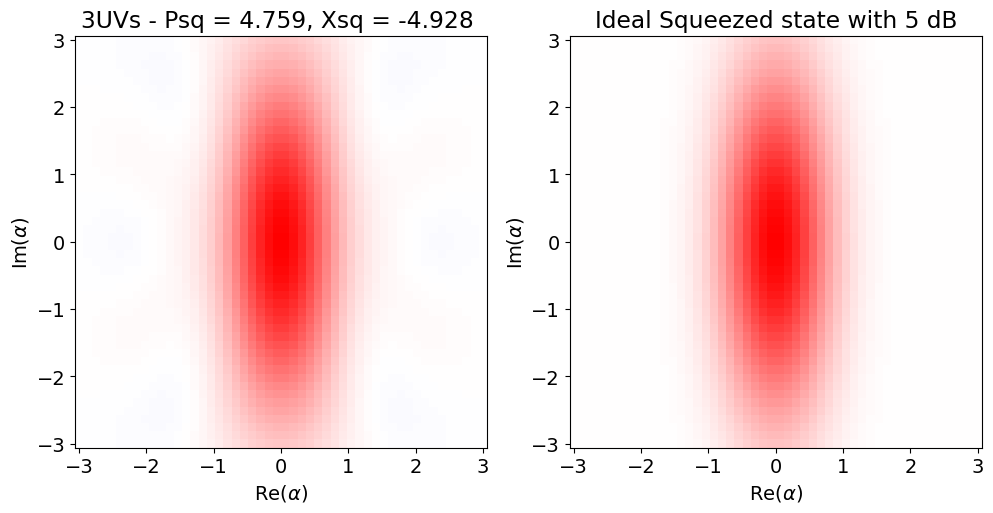

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [64]:
ideal_state = tensor(fock(2,0)*fock(2,0).dag(),squeeze(N,-1*calc_squeez_parameter(squeezing)))*vac

fig , ax = plt.subplots(1,2)

plot_char(psi3, ax = ax[0])
plot_char(ideal_state, ax=ax[1])

ax[0].set_title(f"3UVs - Psq = {dbp}, Xsq = {dbx} ")
ax[1].set_title(f"Ideal Squeezed state with {squeezing} dB")


In [65]:
squeezing = 7
#initial_guess = [ 1,1,1,-1,-1,-1]
initial_guess = [random.randrange(-10, 10, 1)/10 for i in range(6)]

result = optimize.minimize(find_parameters_for_given_squeezing, initial_guess, method= 'SLSQP', args = squeezing )
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

psi1 = V_ideal_operator(fitted_params[1])*U_ideal_operator(fitted_params[0])*vac
psi2 = V_ideal_operator(fitted_params[3])*U_ideal_operator(fitted_params[2])*psi1
psi3 = V_ideal_operator(fitted_params[5])*U_ideal_operator(fitted_params[4])*psi2


#plot_char(psi3)
dbx = np.round(-10*np.log10(qt.expect(X_oper**2,psi3)*4),3)
dbp = np.round(-10*np.log10(qt.expect(P_oper**2,psi3)*4),3)
print(' dbx = ', dbx)
print(' dbp = ', dbp)

Squeezing: 0.45061758458255413
Overlap with ideal squeezed state: (0.7454762412542479+0j)
Squeezing: 0.45061758215512454
Overlap with ideal squeezed state: (0.7454762437964948+0j)
Squeezing: 0.45061763873079913
Overlap with ideal squeezed state: (0.7454762462718713+0j)
Squeezing: 0.4506175664082783
Overlap with ideal squeezed state: (0.7454762428848027+0j)
Squeezing: 0.4506176865096598
Overlap with ideal squeezed state: (0.7454762501870866+0j)
Squeezing: 0.45061759935000106
Overlap with ideal squeezed state: (0.7454762428491555+0j)
Squeezing: 0.4506176588877548
Overlap with ideal squeezed state: (0.7454762500682811+0j)
Squeezing: 0.4080068280030521
Overlap with ideal squeezed state: (0.8581680874861636+0j)
Squeezing: 0.40800678367058885
Overlap with ideal squeezed state: (0.858168086790147+0j)
Squeezing: 0.408006756080021
Overlap with ideal squeezed state: (0.8581680846846704+0j)
Squeezing: 0.4080067748925271
Overlap with ideal squeezed state: (0.8581680862466665+0j)
Squeezing: 0.40800

Text(0.5, 1.0, 'Ideal Squeezed state with 6 dB')

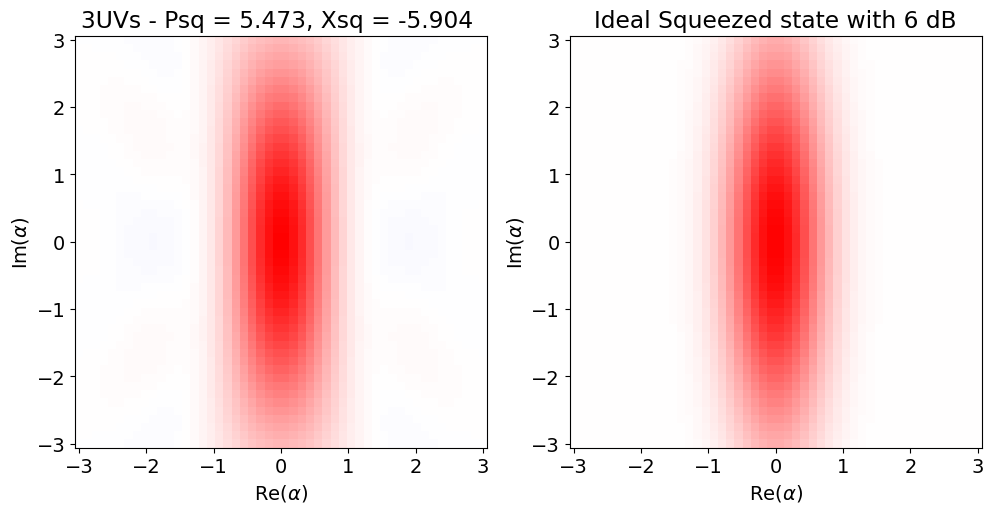

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [66]:
ideal_state = tensor(fock(2,0)*fock(2,0).dag(),squeeze(N,-1*calc_squeez_parameter(squeezing)))*vac

fig , ax = plt.subplots(1,2)

plot_char(psi3, ax = ax[0])
plot_char(ideal_state, ax=ax[1])

ax[0].set_title(f"3UVs - Psq = {dbp}, Xsq = {dbx} ")
ax[1].set_title(f"Ideal Squeezed state with {squeezing} dB")


# 2. Squeezed Cat -> Cat

### a) Fit one of the blobs to extract alpha and squeezing guess

In [ ]:
# finding alpha of the cat by fitting a gaussian to one of the blobs
""" 
Use the above plot to make good intial guesses!
Sometimes, fitting to e.g. the proj_e projection might work better.

"""
scaling = 2.6
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.1, -3, 0.0, 1, 1, 0, 0) # upper blob


xvec = x*scaling # i define it like this in case i want to slice x
yvec = y*scaling
X, Y = np.meshgrid(yvec, xvec)

data = proj_e

popt1, pcov1 = opt.curve_fit(twoD_Gaussian, (X, Y), data.flatten(), p0=initial_guess)



data_fitted1 = twoD_Gaussian((X, Y), *popt1)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
ax.contour(yvec,xvec, data_fitted1.reshape(len(x),len(y)))
ax.set_aspect("equal")
plt.show()

In [ ]:
print('xcenter:',popt1[1])
print('ycenter:',popt1[2])
print('|distance from origin| =',np.sqrt(popt1[1]**2+popt1[2]**2))
# dont forget the factor of two to convert it into an alpha if we are plotting char func.
alpha = np.sqrt(popt1[1]**2+popt1[2]**2)/2
print("\u03B1 is approximately = ", alpha) 

### b) use the function to find gamma to extract alpha
This works by turning squeezing to antisqueezing


In [91]:
find_gamma(1.55555,calc_squeez_parameter(-2))

1.9583214243164169